In [ ]:
!pip install pyodbc

In [ ]:
!pip install pymssql sqlalchemy


In [ ]:
from sqlalchemy import create_engine
import pandas as pd

server = '192.168.0.136'
database = 'data_warehouse_air'
username = 'skander'
password = 'mskanderl97'

#engine = create_engine(f"mssql+pymssql://{username}:{password}@{server}/{database}")

#df1 = pd.read_sql("SELECT * FROM fact_flight_activity", engine)
#df2 = pd.read_sql("SELECT * FROM dim_customer", engine)

df1=pd.read_csv('Customer Flight Activity.csv')
df2=pd.read_csv('Customer Loyalty History.csv')

print("connected successfully")



connected successfully


## It's crucial to start with business understanding, this airline company can benefit very well from exploring this data.

# this notebook (classification model) could be used for example to suggest which Loyalty tier card for new customers or suggest tier card transitions for old customers



necessary imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
df1.shape

(405624, 10)

In [ ]:
df2.shape

(16737, 16)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

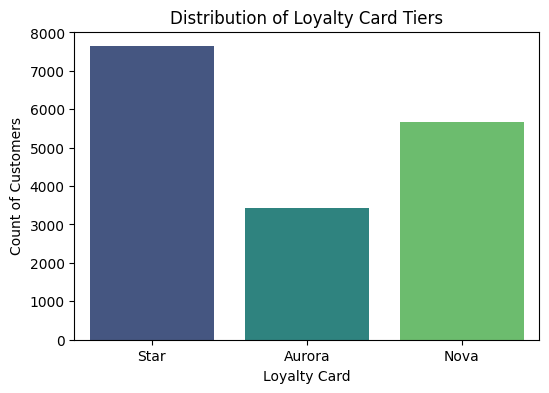

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df2, x='Loyalty Card', hue='Loyalty Card', palette='viridis', legend=False)
plt.title("Distribution of Loyalty Card Tiers")
plt.xlabel("Loyalty Card")
plt.ylabel("Count of Customers")
plt.show()

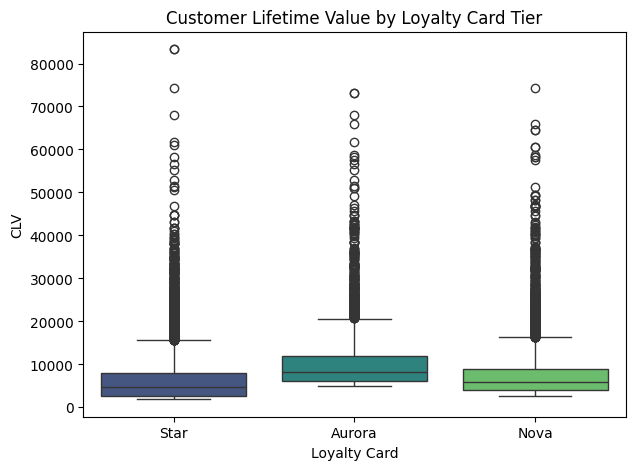

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df2,x='Loyalty Card',y='CLV',hue='Loyalty Card',palette='viridis',legend=False)
plt.title("Customer Lifetime Value by Loyalty Card Tier")
plt.xlabel("Loyalty Card")
plt.ylabel("CLV")
plt.show()


Data Preparation


data cleaning :

remove duplicate:


In [ ]:
df2.duplicated().sum()

np.int64(0)

In [ ]:
df1.duplicated(subset=["Loyalty Number","Year","Month"]).sum()

np.int64(3936)

In [ ]:
df1=df1.drop_duplicates(subset=["Loyalty Number","Year","Month"])

In [ ]:
df1.duplicated().sum()

np.int64(0)

handle missing values:


In [ ]:
df1.isnull().any(axis=1).sum()


np.int64(0)

In [ ]:
df2.isnull().any(axis=1).sum()

np.int64(15197)

so many missing values because of the cancelation date (many customers still didnt cancel)

In [ ]:
df2.drop(['Cancellation Year', 'Cancellation Month'], axis=1, inplace=True)


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Loyalty Number    16737 non-null  int64  
 1   Country           16737 non-null  object 
 2   Province          16737 non-null  object 
 3   City              16737 non-null  object 
 4   Postal Code       16737 non-null  object 
 5   Gender            16737 non-null  object 
 6   Education         16737 non-null  object 
 7   Salary            12499 non-null  float64
 8   Marital Status    16737 non-null  object 
 9   Loyalty Card      16737 non-null  object 
 10  CLV               16737 non-null  float64
 11  Enrollment Type   16737 non-null  object 
 12  Enrollment Year   16737 non-null  int64  
 13  Enrollment Month  16737 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 1.8+ MB


In [ ]:
negative_salary_count = (df2['Salary'] < 0).sum()
print(negative_salary_count)

20


i can remove rows with negative salary it's only 20 rows but i will transform them into missing values instead

In [ ]:
df2.loc[df2['Salary'] < 0, 'Salary'] = pd.NA


In [ ]:
negative_salary_count = (df2['Salary'] < 0).sum()
print(negative_salary_count)

0


impute missing values with mean or median salary

<Axes: xlabel='Salary', ylabel='Count'>

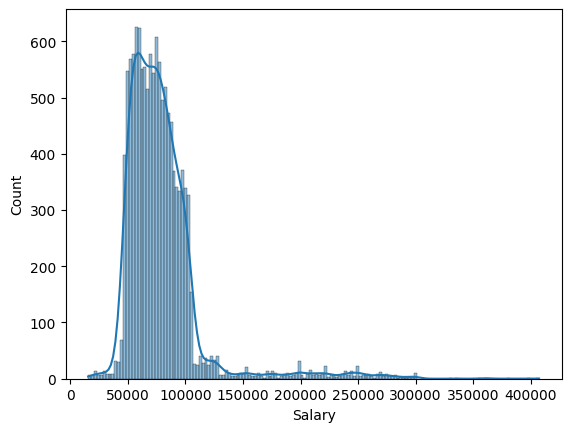

In [ ]:
sns.histplot(df2['Salary'], kde=True)

data presents some right skewness I will use the median instead of the mean

after thinking , maybe missing values here means no salary (no job) because :
- a lot of missing values (hard for it to be a typing mistake)
- a lot of the missing values correspond to ppl in college or in highschool (no job yet)

so i will impute missing salaries with 0

In [ ]:
df2['Salary'].fillna(0, inplace=True)

/tmp/ipython-input-953619366.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Salary'].fillna(0, inplace=True)


In [ ]:
df2['Salary'].isna().sum()

np.int64(0)

In [ ]:
#fil statistique descriptive, outliers houma li lbara mil [Q1 - 1.5 * IQR  ,  Q3 + 1.5 * IQR ]

col = df2['CLV']

Q1 = col.quantile(0.25)
Q3 = col.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = col[(col < lower_bound) | (col > upper_bound)]

num_outliers = outliers.count()
print("number of outliers = ",num_outliers)

percent_outliers = num_outliers / col.count() * 100
print(f"percentage of outliers = {percent_outliers:.2f}%")


number of outliers =  1485
percentage of outliers = 8.87%


In [ ]:
df2['CLV'].skew()


np.float64(3.0708539402746036)

\>0 ===> right skewness confirmed by this histogram :

<Axes: xlabel='CLV', ylabel='Count'>

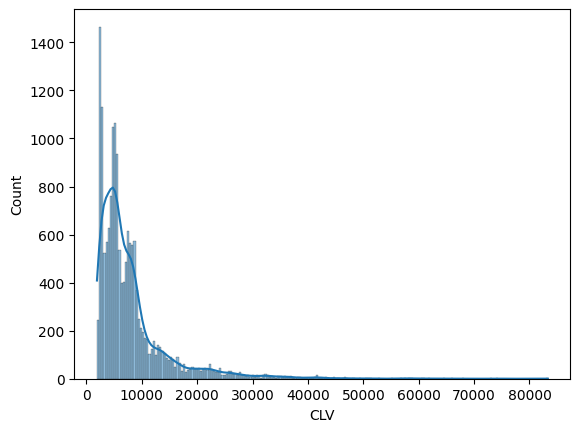

In [ ]:
sns.histplot(df2['CLV'], kde=True)

CLV column contains outliers , but I will leave them because they are reasonable values and they are relevant

note : both CLV and Salary present right skewness this is not a coincidence.

this happens because


In [ ]:
df1.head(10)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0
5,100301,2017,1,0,0,0,0,0.0,0,0
6,100364,2017,1,0,0,0,0,0.0,0,0
7,100380,2017,1,0,0,0,0,0.0,0,0
8,100428,2017,1,6,0,6,606,60.0,0,0
9,100504,2017,1,0,0,0,0,0.0,0,0


In [ ]:
filtered_rows = df1[df1['Loyalty Number'] == 100380]

print(filtered_rows)

        Loyalty Number  Year  Month  Flights Booked  Flights with Companions  \
7               100380  2017      1               0                        0   
16908           100380  2017      2               4                        3   
50710           100380  2017      4               4                        3   
67611           100380  2017      5              11                        0   
84512           100380  2017      6               3                        3   
101413          100380  2017      7               0                        0   
118314          100380  2017      8              10                        6   
127353          100380  2017      3               3                        3   
135215          100380  2017      9               0                        0   
152116          100380  2017     10              13                        0   
185918          100380  2017     12               0                        0   
202819          100380  2018      1     

In [ ]:
df1 = df1.groupby('Loyalty Number').sum().reset_index()


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Loyalty Number               16737 non-null  int64  
 1   Year                         16737 non-null  int64  
 2   Month                        16737 non-null  int64  
 3   Flights Booked               16737 non-null  int64  
 4   Flights with Companions      16737 non-null  int64  
 5   Total Flights                16737 non-null  int64  
 6   Distance                     16737 non-null  int64  
 7   Points Accumulated           16737 non-null  float64
 8   Points Redeemed              16737 non-null  int64  
 9   Dollar Cost Points Redeemed  16737 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 1.3 MB


In [ ]:
filtered_rows = df1[df1['Loyalty Number'] == 100380]

print(filtered_rows)

   Loyalty Number   Year  Month  Flights Booked  Flights with Companions  \
7          100380  48420    156             116                       43   

   Total Flights  Distance  Points Accumulated  Points Redeemed  \
7            159     35812              3593.0             1142   

   Dollar Cost Points Redeemed  
7                           92  


In [ ]:
df1.drop(columns=['Year', 'Month'], inplace=True)

In [ ]:
df1.head(10)

,Loyalty Number,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,157,35,192,50682,5376.00,1513,123
1,100102,173,42,215,40222,4115.25,1195,96
2,100140,152,38,190,41252,4184.25,593,48
3,100214,79,17,96,33982,3426.00,861,70
4,100272,127,36,163,40872,4108.04,1007,82
5,100301,145,46,191,42594,4273.00,1381,112
6,100364,111,28,139,32211,3217.00,559,45
7,100380,116,43,159,35812,3593.00,1142,92
8,100428,121,22,143,34495,3513.00,1658,134
9,100504,67,6,73,15911,1709.00,0,0


In [ ]:
df2.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,0.0,Divorced,Star,3839.61,Standard,2016,3
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,0.0,Single,Star,3839.75,Standard,2014,7
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,0.0,Single,Star,3839.75,Standard,2013,2
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10


In [ ]:
df3 = pd.merge(df1, df2, on='Loyalty Number')

data transformation

encoding


<Figure size 1000x600 with 0 Axes>

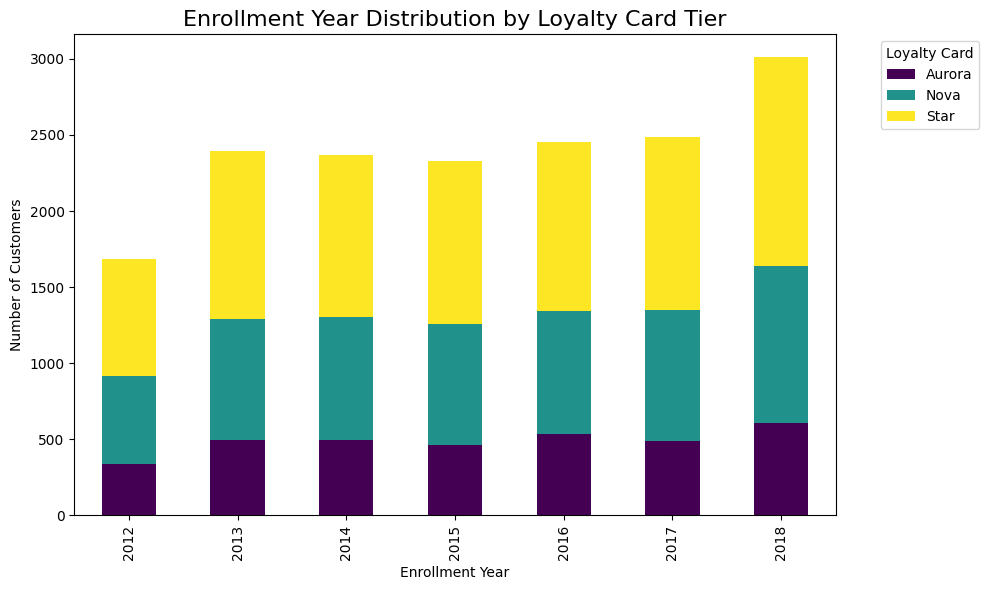

In [ ]:
# Enrollment year distribution
plt.figure(figsize=(10,6))
enrollment_counts = df3.groupby(['Enrollment Year', 'Loyalty Card']).size().unstack()
enrollment_counts.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title("Enrollment Year Distribution by Loyalty Card Tier", fontsize=16)
plt.xlabel("Enrollment Year")
plt.ylabel("Number of Customers")
plt.legend(title='Loyalty Card', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal = OrdinalEncoder(categories=[[ 'High School or Below', 'College', 'Bachelor','Master','Doctor']])
df2.Education = ordinal.fit_transform(df2.Education.values.reshape(-1, 1))

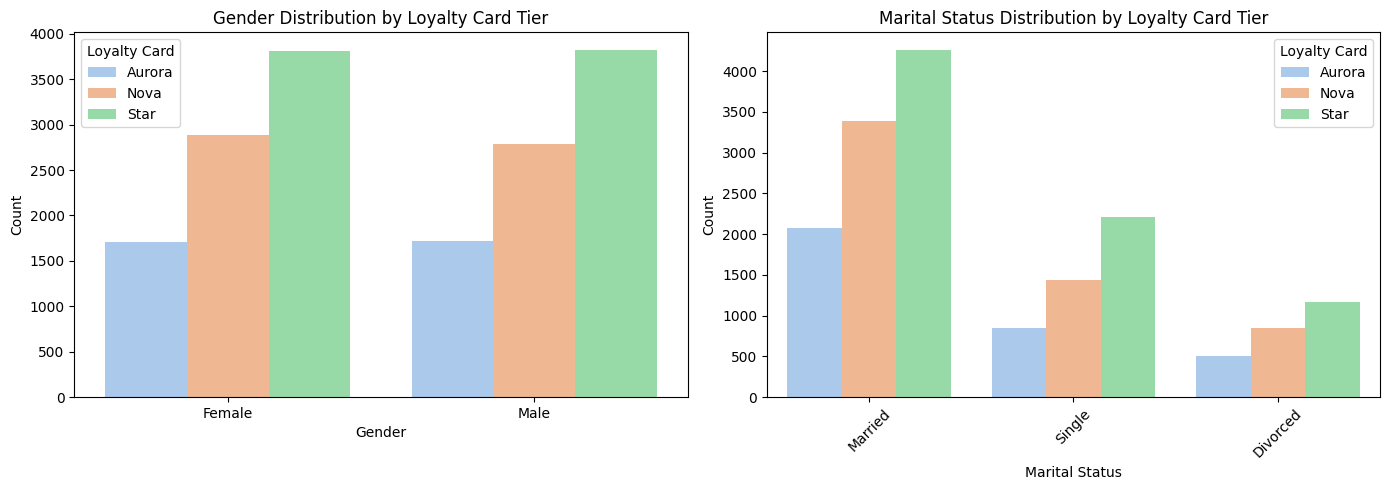

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.countplot(data=df3, x='Gender', hue='Loyalty Card', ax=axes[0], palette='pastel')
axes[0].set_title("Gender Distribution by Loyalty Card Tier")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")


sns.countplot(data=df3, x='Marital Status', hue='Loyalty Card', ax=axes[1], palette='pastel')
axes[1].set_title("Marital Status Distribution by Loyalty Card Tier")
axes[1].set_xlabel("Marital Status")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
contingency_table = pd.crosstab(df2['Marital Status'], df2['Loyalty Card'])
print(contingency_table)
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi2 statistic:", chi2)
print("p-value:", p)


Loyalty Card    Aurora  Nova  Star
Marital Status                    
Divorced           504   849  1165
Married           2080  3391  4264
Single             845  1431  2208
Chi2 statistic: 37.77772018075393
p-value: 1.245323506965427e-07


small p value which usually means there is correlation but small chi2 which means that marital status barely predicts card type.

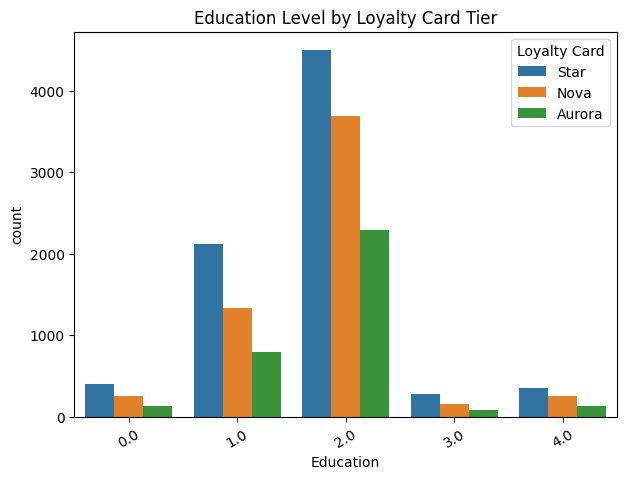

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(data=df2, x='Education', hue='Loyalty Card')
plt.xticks(rotation=30)
plt.title("Education Level by Loyalty Card Tier")
plt.show()


In [ ]:
#df1.drop(columns=['Total Flights', 'Dollar Cost Points Redeemed'], inplace=True)

In [ ]:
df3 = pd.merge(df1, df2, on='Loyalty Number')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
df3['loyalty_card'] = le.fit_transform(df3['Loyalty Card'])


In [ ]:
df3.head()

,Loyalty Number,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,...,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,loyalty_card
0,100018,157,35,192,50682,5376.00,1513,123,Canada,Alberta,...,Female,2.0,92552.0,Married,Aurora,7919.20,Standard,2016,8,0
1,100102,173,42,215,40222,4115.25,1195,96,Canada,Ontario,...,Male,1.0,0.0,Single,Nova,2887.74,Standard,2013,3,1
2,100140,152,38,190,41252,4184.25,593,48,Canada,British Columbia,...,Female,1.0,0.0,Divorced,Nova,2838.07,Standard,2016,7,1
3,100214,79,17,96,33982,3426.00,861,70,Canada,British Columbia,...,Male,2.0,63253.0,Married,Star,4170.57,Standard,2015,8,2
4,100272,127,36,163,40872,4108.04,1007,82,Canada,Ontario,...,Female,2.0,91163.0,Divorced,Star,6622.05,Standard,2014,1,2


In [ ]:
df3.head()

,Loyalty Number,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,...,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,loyalty_card
0,100018,157,35,192,50682,5376.00,1513,123,Canada,Alberta,...,Female,2.0,92552.0,Married,Aurora,7919.20,Standard,2016,8,0
1,100102,173,42,215,40222,4115.25,1195,96,Canada,Ontario,...,Male,1.0,0.0,Single,Nova,2887.74,Standard,2013,3,1
2,100140,152,38,190,41252,4184.25,593,48,Canada,British Columbia,...,Female,1.0,0.0,Divorced,Nova,2838.07,Standard,2016,7,1
3,100214,79,17,96,33982,3426.00,861,70,Canada,British Columbia,...,Male,2.0,63253.0,Married,Star,4170.57,Standard,2015,8,2
4,100272,127,36,163,40872,4108.04,1007,82,Canada,Ontario,...,Female,2.0,91163.0,Divorced,Star,6622.05,Standard,2014,1,2


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Loyalty Number               16737 non-null  int64  
 1   Flights Booked               16737 non-null  int64  
 2   Flights with Companions      16737 non-null  int64  
 3   Total Flights                16737 non-null  int64  
 4   Distance                     16737 non-null  int64  
 5   Points Accumulated           16737 non-null  float64
 6   Points Redeemed              16737 non-null  int64  
 7   Dollar Cost Points Redeemed  16737 non-null  int64  
 8   Country                      16737 non-null  object 
 9   Province                     16737 non-null  object 
 10  City                         16737 non-null  object 
 11  Postal Code                  16737 non-null  object 
 12  Gender                       16737 non-null  object 
 13  Education       

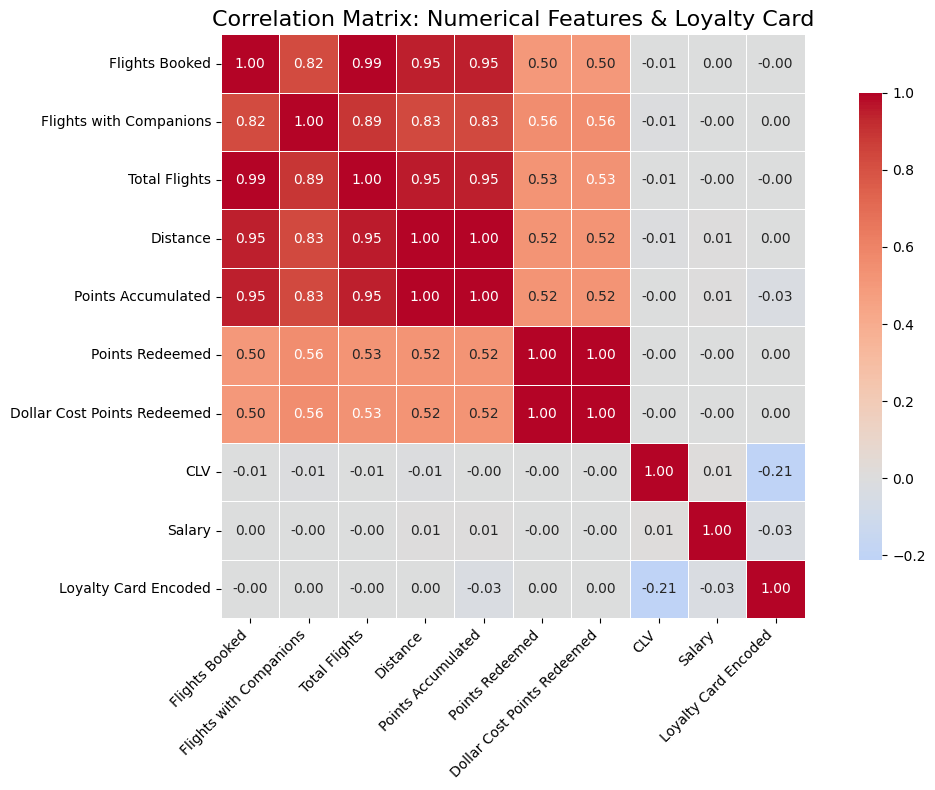

In [ ]:
# Encode loyalty card temporarily for correlation
df_corr = df3.copy()
df_corr['Loyalty Card Encoded'] = le.fit_transform(df_corr['Loyalty Card'])

# Select numerical features
num_features = ['Flights Booked', 'Flights with Companions', 'Total Flights',
                'Distance', 'Points Accumulated', 'Points Redeemed',
                'Dollar Cost Points Redeemed', 'CLV', 'Salary', 'Loyalty Card Encoded']

plt.figure(figsize=(12, 8))
corr_matrix = df_corr[num_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix: Numerical Features & Loyalty Card", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
features = ['Distance','CLV','Points Accumulated','Total Flights','Points Redeemed']
target = 'loyalty_card'

X = df3[features]
y = df3[target]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y) #,stratify=y


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
knn = KNeighborsClassifier()


param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11,13],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]        # 1 Manhattan, 2 Euclidean
}


grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test_scaled)

print("Test set accuracy:", grid_search.score(X_test_scaled, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best cross-validation accuracy: 0.48629439004514713
Test set accuracy: 0.48566308243727596
Confusion Matrix:
 [[ 212  262  212]
 [ 152  393  589]
 [ 144  363 1021]]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.31      0.36       686
           1       0.39      0.35      0.37      1134
           2       0.56      0.67      0.61      1528

    accuracy                           0.49      3348
   macro avg       0.45      0.44      0.44      3348
weighted avg       0.47      0.49      0.47      3348



l
et's try adding PCA now , because KNN is distance based and can suffer from "curse of dimensionality"

PCA Visualization of Original Features:


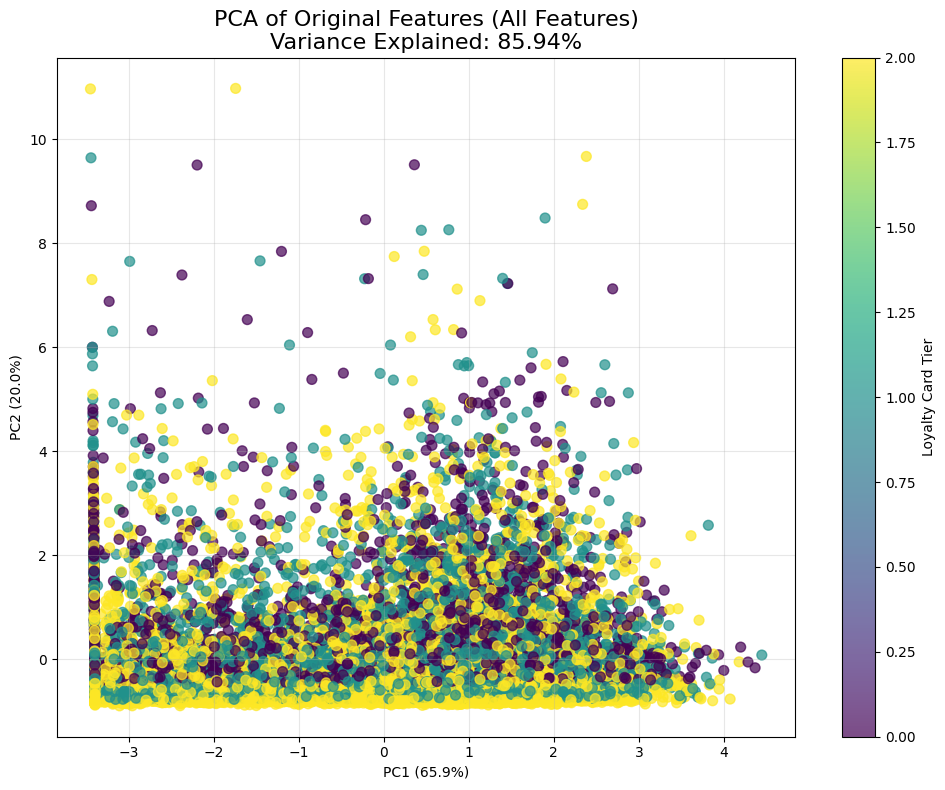


Variance Analysis:


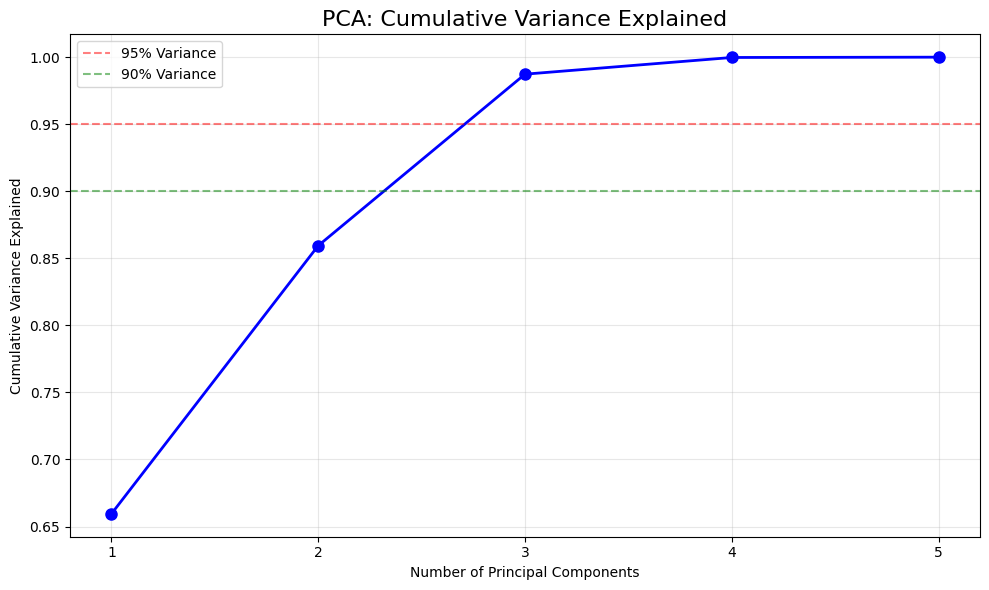

Components for 80% variance: 2
Components for 90% variance: 3
Components for 95% variance: 3
Components for 99% variance: 4


In [ ]:

# Create a PCA visualization function
def plot_pca_2d(X_scaled, y, title="PCA 2D Projection"):
    """
    Plot 2D PCA projection of the data
    """
    pca_2d = PCA(n_components=2, random_state=42)
    X_pca_2d = pca_2d.fit_transform(X_scaled)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                          c=y, cmap='viridis', alpha=0.7, s=50)
    plt.title(f"{title}\nVariance Explained: {pca_2d.explained_variance_ratio_.sum():.2%}", fontsize=16)
    plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})")
    plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})")
    plt.colorbar(scatter, label='Loyalty Card Tier')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return pca_2d, X_pca_2d

# Plot PCA of your current data
print("PCA Visualization of Original Features:")
pca_vis, X_pca_vis = plot_pca_2d(scaler.fit_transform(X), y,
                                  "PCA of Original Features (All Features)")

# Also visualize variance explained by components
def plot_variance_explained(X_scaled, max_components=None):
    """
    Plot cumulative variance explained by PCA components
    """
    if max_components is None:
        max_components = min(X_scaled.shape[1], 10)

    pca_full = PCA(n_components=max_components, random_state=42)
    pca_full.fit(X_scaled)

    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), cumulative_variance, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% Variance')
    plt.axhline(y=0.90, color='g', linestyle='--', alpha=0.5, label='90% Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('PCA: Cumulative Variance Explained', fontsize=16)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xticks(range(1, max_components + 1))
    plt.tight_layout()
    plt.show()

    # Print how many components needed for certain variance thresholds
    for threshold in [0.8, 0.9, 0.95, 0.99]:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        print(f"Components for {threshold:.0%} variance: {n_components}")

    return pca_full

print("\nVariance Analysis:")
pca_full = plot_variance_explained(scaler.fit_transform(X))

In [ ]:
pipeline_pca_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])



param_grid_pca = {
    'pca__n_components': [2, 3, 4, 5, None],
    'pca__whiten': [True, False],
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}



print("=" * 60)
print("GRID SEARCH WITH PCA + KNN")
print("=" * 60)

grid_search_pca = GridSearchCV(
    estimator=pipeline_pca_knn,
    param_grid=param_grid_pca,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_pca.fit(X_train, y_train)

print("\nBest parameters with PCA:")
print(grid_search_pca.best_params_)
print(f"Best cross-validation accuracy with PCA: {grid_search_pca.best_score_:.4f}")

GRID SEARCH WITH PCA + KNN
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Best parameters with PCA:
{'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance', 'pca__n_components': 5, 'pca__whiten': True}
Best cross-validation accuracy with PCA: 0.7017


COMPARISON: ORIGINAL KNN vs PCA-KNN

Performance Comparison:
       Model  CV Accuracy  Test Accuracy                                                                                                     Parameters
Original KNN     0.486294       0.485663                                                             {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
     PCA-KNN     0.701695       0.696535 {'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance', 'pca__n_components': 5, 'pca__whiten': True}


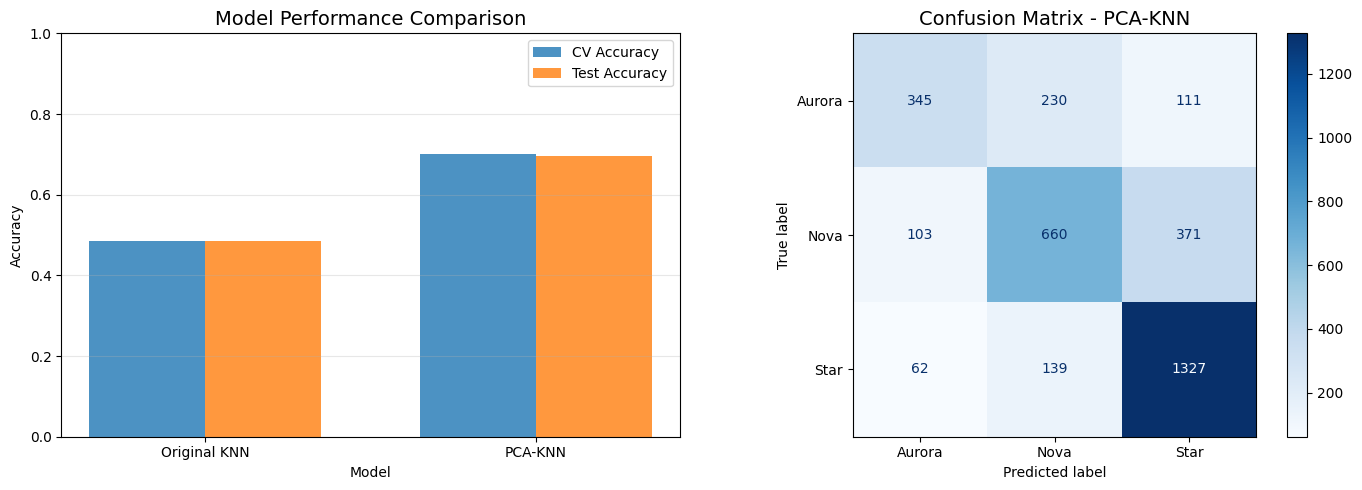

In [ ]:


print("=" * 60)
print("COMPARISON: ORIGINAL KNN vs PCA-KNN")
print("=" * 60)


y_pred_original = grid_search.predict(X_test_scaled)
accuracy_original = grid_search.score(X_test_scaled, y_test)


y_pred_pca = grid_search_pca.predict(X_test)
accuracy_pca = grid_search_pca.score(X_test, y_test)



comparison_df = pd.DataFrame({
    'Model': ['Original KNN', 'PCA-KNN'],
    'CV Accuracy': [grid_search.best_score_, grid_search_pca.best_score_],
    'Test Accuracy': [accuracy_original, accuracy_pca],
    'Parameters': [str(grid_search.best_params_), str(grid_search_pca.best_params_)]
})

print("\nPerformance Comparison:")
print(comparison_df.to_string(index=False))



fig, axes = plt.subplots(1, 2, figsize=(14, 5))


models = ['Original KNN', 'PCA-KNN']
cv_scores = [grid_search.best_score_, grid_search_pca.best_score_]
test_scores = [accuracy_original, accuracy_pca]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, cv_scores, width, label='CV Accuracy', alpha=0.8)
axes[0].bar(x + width/2, test_scores, width, label='Test Accuracy', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Performance Comparison', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])


from sklearn.metrics import ConfusionMatrixDisplay


axes[1].set_title('Confusion Matrix - PCA-KNN', fontsize=14)
ConfusionMatrixDisplay.from_estimator(grid_search_pca, X_test, y_test,
                                      ax=axes[1], cmap='Blues',
                                      display_labels=le.classes_)
axes[1].grid(False)

plt.tight_layout()
plt.show()

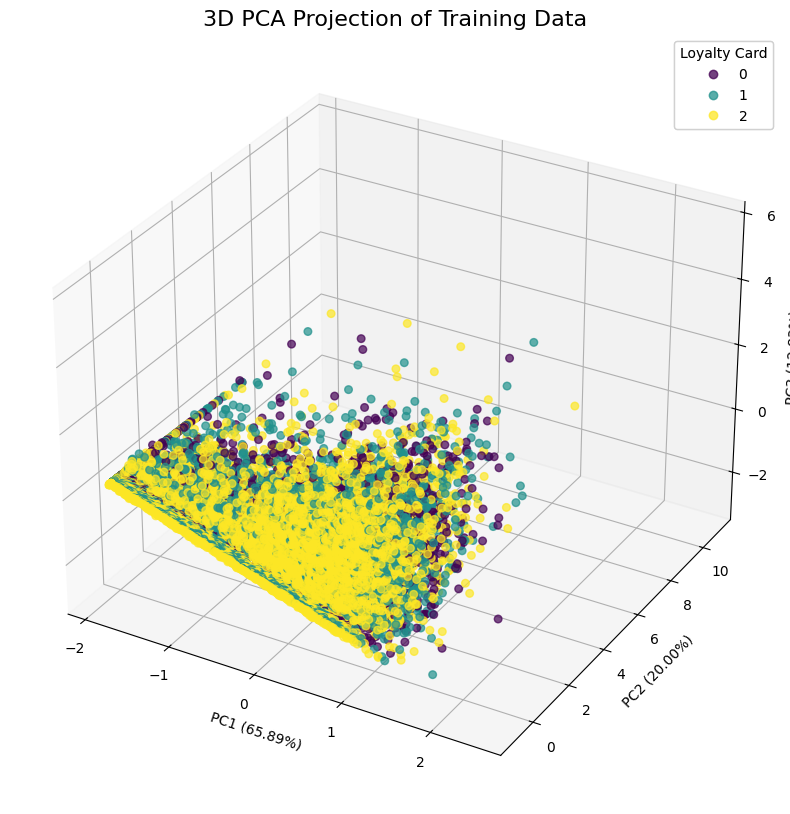

In [ ]:
best_pipeline = grid_search_pca.best_estimator_
best_scaler = best_pipeline.named_steps['scaler']
best_pca = best_pipeline.named_steps['pca']

if best_pca.n_components_ >= 3:
    X_train_scaled = best_scaler.transform(X_train)
    X_pca_3d = best_pca.transform(X_train_scaled)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                         c=y_train, cmap='viridis', alpha=0.7, s=30)

    ax.set_xlabel(f'PC1 ({best_pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({best_pca.explained_variance_ratio_[1]:.2%})')
    ax.set_zlabel(f'PC3 ({best_pca.explained_variance_ratio_[2]:.2%})')
    ax.set_title('3D PCA Projection of Training Data', fontsize=16)


    legend1 = ax.legend(*scatter.legend_elements(), title="Loyalty Card")
    ax.add_artist(legend1)

    plt.show()

# fun experiment : is skander smarter than dummy ?

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy = DummyClassifier(strategy="most_frequent", random_state=42)

dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

dummy_accuracy = accuracy_score(y_test, y_pred_dummy)

print("Dummy Classifier Accuracy:", dummy_accuracy)


print("Confusion Matrix (Dummy):\n", confusion_matrix(y_test, y_pred_dummy))
print("Classification Report (Dummy):\n", classification_report(y_test, y_pred_dummy))



Dummy Classifier Accuracy: 0.45639187574671447
Confusion Matrix (Dummy):
 [[   0    0  686]
 [   0    0 1134]
 [   0    0 1528]]
Classification Report (Dummy):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       686
           1       0.00      0.00      0.00      1134
           2       0.46      1.00      0.63      1528

    accuracy                           0.46      3348
   macro avg       0.15      0.33      0.21      3348
weighted avg       0.21      0.46      0.29      3348



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
dummy_stratified = DummyClassifier(strategy="stratified", random_state=42)

dummy_stratified.fit(X_train, y_train)
y_pred_strat = dummy_stratified.predict(X_test)

print("Stratified Dummy Accuracy:", accuracy_score(y_test, y_pred_strat))


Stratified Dummy Accuracy: 0.3593189964157706


In [ ]:
import joblib


joblib.dump(grid_search_pca, 'tier_model.pkl')
print("PCA + KNN model saved to 'pca_knn_model.pkl'")



PCA + KNN model saved to 'pca_knn_model.pkl'


# **Conclusion of the fun experiment :**
 yes skander is smarter than dummy (but not by a lot)